In [17]:
import wandb
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
import plotly.graph_objects as go
from datetime import timedelta
import os
import re
import joblib
import io
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from scripts.SEP_CFE_functions import *
min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")

In [18]:
wandb.init(
    entity="gsu-dmlab",
    project="SEPCFE",  # You choose the project name
    name="Exp4.1_Fidelity_evaluation_of_CFEs",  # Give each run a name
    config={
        "model": "RandomForestClassifier_model_sep_cfe.pkl",
        "data_version": "mean_sliced",
        "explainer_random": "sep_cfe_random_explainer.pkl",
        "explainer_genetic": "sep_cfe_genetic_explainer.pkl"
    }
)

In [19]:
abt_path_train = '../data/raw/mean_sliced/train_data.csv'
df_train = pd.read_csv(abt_path_train,  sep=',',index_col=0)
abt_path_test = '../data/raw/mean_sliced/test_data.csv'
df_test = pd.read_csv(abt_path_test, sep=',',index_col=0)
abt_path_val = '../data/raw/mean_sliced/valid_data.csv'
df_val = pd.read_csv(abt_path_val, sep=',',index_col=0)

In [20]:
X_train=pd.read_csv('../data/processed/X_train.csv',sep=',',index_col=0)
Y_train=pd.read_csv('../data/processed/Y_train.csv',sep=',',index_col=0)
X_test=pd.read_csv('../data/processed/X_test.csv',sep=',',index_col=0)
Y_test=pd.read_csv('../data/processed/Y_test.csv',sep=',',index_col=0)
X_val=pd.read_csv('../data/processed/X_val.csv',sep=',',index_col=0)
Y_val=pd.read_csv('../data/processed/Y_val.csv',sep=',',index_col=0)
df_multi_labels = pd.read_excel("../data/raw/multi_labels.xlsx",header=0)
df_multi_labels = df_multi_labels[df_multi_labels['File'] != '1991-06-18_23-16.csv']
df_combined_labels=pd.read_csv('../data/processed/df_combined_labels.csv',sep=',',index_col=0)


In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
all_entries = os.listdir('../data/raw/data/')        # no wildcard here
csv_files = [f for f in all_entries if f.lower().endswith('.csv')]
df_combined_labels['not_exists'] = ~df_combined_labels['File'].str.lower().isin(csv_files)
missing = df_combined_labels[df_combined_labels['not_exists']]
print(missing[['File', 'not_exists','Label','Event_Y_N']])
print(df_combined_labels.shape)


    File  not_exists  Label  Event_Y_N
743  NaN        True   -1.0        0.0
(2893, 933)


In [22]:
# Load model
RandomForestClassifier_sep_cfe = joblib.load('../models/RandomForestClassifier_model_sep_cfe.pkl')
Y_pred = RandomForestClassifier_sep_cfe.predict(X_train)
#
# # Output the test classification report and confusion matrix
# print("\nTest Classification Report:\n", classification_report(Y_train, Y_pred))
# print("Test Confusion Matrix:\n", confusion_matrix(Y_train, Y_pred))

**Counterfactual Explainations for SEP Prediction**

In [23]:
df_cfe = df_test.drop(["Label"],axis=1)
#df_cfe = df_combined_labels.drop(["Label","File","Label.1"],axis=1)  # should contain the target column
cont_features = list(df_combined_labels.drop(["Label","Event_Y_N","File","Multi_Label"],axis=1).columns) #should not contain target column

In [24]:
exp_random = joblib.load("../models/sep_cfe_random_explainer.pkl")
exp_genetic = joblib.load("../models/sep_cfe_genetic_explainer.pkl")

In [25]:
feature_names = X_train.columns
k=928
sorted_normalized_weights_df  = get_feature_importance(RandomForestClassifier_sep_cfe,feature_names)
top_k_features = sorted_normalized_weights_df['Feature'].head(k).to_list()
top_k_normalized_weights_dict = sorted_normalized_weights_df.head(k).set_index('Feature')['Normalized Importance'].to_dict()
# print(top_k_normalized_weights_dict)


In [26]:
p3_flux_cols = [col for col in df_train.columns if 'p3_flux_ic_mean' in col]
p5_flux_cols = [col for col in df_train.columns if 'p5_flux_ic_mean' in col]
p7_flux_cols = [col for col in df_train.columns if 'p7_flux_ic_mean' in col]

In [27]:
pattern = r'^(p3_flux_ic_mean|p5_flux_ic_mean|p7_flux_ic_mean|long_mean)@\[(\d+:\d+)\]$'
header_list = df_train.columns.astype(str).str.cat(sep="\t").split()
slices = extract_slices_from_headers(header_list,pattern,"p3_flux_ic_mean")


Experiment 1  Fidelity Evaluation with Records after 2003

In [28]:
#Function to log confusion matrix to wandb
def log_conf_mat(cm, display_labels, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap='cividis', colorbar=False)
    ax.title.set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(colors='white')

    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    wandb.log({f"Title/{title}": wandb.Image(img)})
    plt.close(fig)


In [29]:
df_test_SEP_post_2003=df_combined_labels.iloc[1970:]
X_df_test_SEP_post_2003 = df_test_SEP_post_2003.drop(["Label", "Event_Y_N", "Multi_Label", "File", "not_exists"], axis=1)
Y_df_test_SEP_post_2003 = df_test_SEP_post_2003['Event_Y_N']
Y_df_test_SEP_post_2003_pred = RandomForestClassifier_sep_cfe.predict(X_df_test_SEP_post_2003)
# --- Handle NaN values --- #
mask = ~Y_df_test_SEP_post_2003.isna()
Y_true_no_nan = Y_df_test_SEP_post_2003[mask]
Y_pred_no_nan = Y_df_test_SEP_post_2003_pred[mask]
cm = confusion_matrix(Y_true_no_nan,Y_pred_no_nan)
log_conf_mat(cm, display_labels=[1, 0], title="ConfusionMatrix_of_records_(post 2003)")


In [30]:
df_query_instances = df_test_SEP_post_2003.copy()
df_query_instances['Predicted_Event_Y_N']=Y_df_test_SEP_post_2003_pred
#filtering true positive and true negative for CFE generation
true_positives_query_instances = df_query_instances[(df_query_instances['Event_Y_N']==1) & (df_query_instances['Predicted_Event_Y_N']==1)]
true_negatives_query_instances = df_query_instances[(df_query_instances['Event_Y_N']==0) & (df_query_instances['Predicted_Event_Y_N']==0)]
print(f"count of true positive query instances:{true_positives_query_instances.shape[0]}\ncount of True negative query instances:{true_negatives_query_instances.shape[0]}")


count of true positive query instances:69
count of True negative query instances:722


Generating Opposite Class Counterfactuals for True Positive SEP events:

In [31]:
true_positives_query_instances_copy = true_positives_query_instances.drop(["Label", "Event_Y_N", "Multi_Label", "File", "not_exists","Predicted_Event_Y_N"], axis=1)
cfe_exp=[]
df_cfe_exp_genetic_TP = pd.DataFrame()
for idx, row in true_positives_query_instances_copy.iterrows():
    try:
        query_instance_df = pd.DataFrame([row])
        query_ts_filename = true_positives_query_instances.loc[idx,'File']
        csv_path = os.path.join('../data/raw/data', query_ts_filename)
        filtered_dict = extract_feature_ranges(csv_path,delim=',', slices=slices, top_k_features=top_k_features,flux_types = ['p3_flux_ic','p5_flux_ic','p7_flux_ic'])
        cfe_genetic = exp_genetic.generate_counterfactuals(
        query_instance_df,  #multiple query instances can be provided as an input dataframe
        total_CFs=1,  # Number of counterfactual examples to generate
        desired_class=0,#'opposite' #,  # Specify the desired class for a continuous target variable
        permitted_range=filtered_dict
        )
        cfe_df = cfe_genetic.cf_examples_list[0].final_cfs_df
        if not cfe_df.empty:
            cfe_exp.append(cfe_df)
            df_cfe_exp_genetic_TP = pd.concat([df_cfe_exp_genetic_TP, cfe_df], ignore_index=True)
        else:
            print(f"No counterfactuals generated for index {idx}")
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        continue








100%|██████████| 1/1 [00:32<00:00, 32.91s/it]


Error at index 2006: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:32<00:00, 32.96s/it]


Error at index 2045: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:33<00:00, 33.47s/it]


Error at index 2046: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:34<00:00, 34.28s/it]


Error at index 2047: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.91s/it]


Error at index 2152: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.87s/it]


Error at index 2153: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.44s/it]


Error at index 2170: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.04s/it]


Error at index 2199: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.93s/it]


Error at index 2200: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.37s/it]


Error at index 2208: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.45s/it]


Error at index 2216: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.82s/it]


Error at index 2236: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:42<00:00, 42.16s/it]


Error at index 2237: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.29s/it]


Error at index 2238: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.57s/it]


Error at index 2239: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:20<00:00, 80.65s/it]


Error at index 2337: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:57<00:00, 57.26s/it]


Error at index 2389: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.71s/it]


Error at index 2390: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.04s/it]


Error at index 2424: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.06s/it]


Error at index 2431: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.34s/it]


Error at index 2707: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.13s/it]


Error at index 2798: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


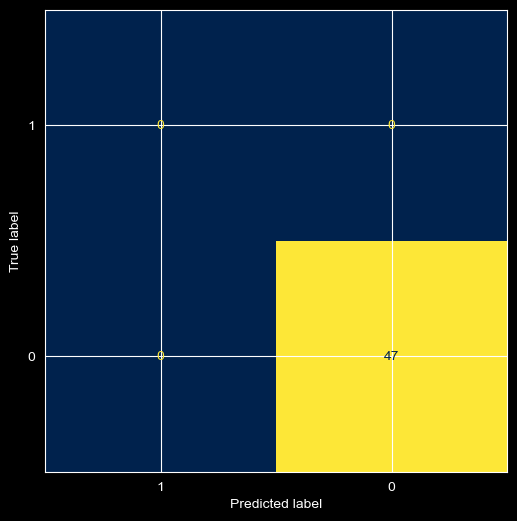

In [32]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(6, 6))
X_df_cfe_exp_genetic_TP = df_cfe_exp_genetic_TP.drop(["Event_Y_N"], axis=1)
Y_df_cfe_exp_genetic_TP = df_cfe_exp_genetic_TP['Event_Y_N']
Y_df_cfe_exp_genetic_TP_pred = RandomForestClassifier_sep_cfe.predict(X_df_cfe_exp_genetic_TP)
cm1 = confusion_matrix(Y_df_cfe_exp_genetic_TP, Y_df_cfe_exp_genetic_TP_pred, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[1, 0])
disp.plot(ax=ax, cmap='cividis', colorbar=False)
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(colors='white')

plt.show()


Generating Counterfactuals of Opposite Class for True Negative SEP events

In [33]:
true_negatives_query_instances_copy = true_negatives_query_instances[:70].drop(["Label", "Event_Y_N", "Multi_Label", "File", "not_exists","Predicted_Event_Y_N"], axis=1)
cfe_exp=[]
df_cfe_exp_genetic_TN = pd.DataFrame()
for idx, row in true_negatives_query_instances_copy.iterrows():
    try:
        query_instance_df = pd.DataFrame([row])
        query_ts_filename = true_negatives_query_instances.loc[idx,'File']
        csv_path = os.path.join('../data/raw/data/', query_ts_filename)
        filtered_dict = extract_feature_ranges(csv_path,delim=',', slices=slices, top_k_features=top_k_features,flux_types = ['p3_flux_ic','p5_flux_ic','p7_flux_ic'])
        cfe_genetic = exp_genetic.generate_counterfactuals(
        query_instance_df,  #multiple query instances can be provided as an input dataframe
        total_CFs=1,  # Number of counterfactual examples to generate
        desired_class=1,#'opposite' #,  # Specify the desired class for a continuous target variable
        permitted_range=filtered_dict
        )
        cfe_df = cfe_genetic.cf_examples_list[0].final_cfs_df
        if not cfe_df.empty:
            cfe_exp.append(cfe_df)
            df_cfe_exp_genetic_TN = pd.concat([df_cfe_exp_genetic_TN, cfe_df], ignore_index=True)
        else:
            print(f"No counterfactuals generated for index {idx}")
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        continue

100%|██████████| 1/1 [00:35<00:00, 35.40s/it]


Error at index 1970: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:39<00:00, 39.76s/it]


Error at index 1971: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.23s/it]


Error at index 1972: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.19s/it]


Error at index 1973: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.80s/it]


Error at index 1974: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.34s/it]


Error at index 1975: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.56s/it]


Error at index 1976: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.80s/it]


Error at index 1978: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.39s/it]


Error at index 1979: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.50s/it]


Error at index 1980: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:35<00:00, 35.76s/it]


Error at index 1981: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:36<00:00, 36.51s/it]


Error at index 1982: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:42<00:00, 42.47s/it]


Error at index 1983: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:41<00:00, 41.96s/it]


Error at index 1984: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:17<00:00, 77.36s/it]


Error at index 1987: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:05<00:00, 65.79s/it]


Error at index 1989: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:55<00:00, 55.35s/it]


Error at index 1990: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:46<00:00, 46.00s/it]


Error at index 1991: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:45<00:00, 45.25s/it]


Error at index 1992: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:47<00:00, 47.45s/it]


Error at index 1993: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:47<00:00, 47.18s/it]


Error at index 1994: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:56<00:00, 56.42s/it]


Error at index 1995: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:09<00:00, 69.21s/it]


Error at index 1996: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:07<00:00, 67.71s/it]


Error at index 1997: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:09<00:00, 69.47s/it]


Error at index 1998: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:09<00:00, 69.03s/it]


Error at index 1999: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:24<00:00, 84.49s/it]


Error at index 2000: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:17<00:00, 77.63s/it]


Error at index 2001: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:09<00:00, 69.70s/it]


Error at index 2002: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:08<00:00, 68.53s/it]


Error at index 2003: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:49<00:00, 49.99s/it]


Error at index 2009: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.33s/it]


Error at index 2010: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.83s/it]


Error at index 2011: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.12s/it]


Error at index 2012: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:39<00:00, 39.07s/it]


Error at index 2015: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.11s/it]


Error at index 2016: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.87s/it]


Error at index 2017: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:39<00:00, 39.21s/it]


Error at index 2018: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.49s/it]


Error at index 2019: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 37.97s/it]


Error at index 2020: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:37<00:00, 38.00s/it]


Error at index 2021: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:47<00:00, 47.07s/it]


Error at index 2022: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:48<00:00, 48.79s/it]


Error at index 2023: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:49<00:00, 49.24s/it]


Error at index 2024: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:42<00:00, 42.87s/it]


Error at index 2025: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.66s/it]


Error at index 2026: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.40s/it]


Error at index 2027: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:39<00:00, 39.43s/it]


Error at index 2028: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:40<00:00, 40.03s/it]


Error at index 2029: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:40<00:00, 40.13s/it]


Error at index 2031: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:38<00:00, 38.17s/it]


Error at index 2032: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:40<00:00, 40.69s/it]


Error at index 2033: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:59<00:00, 59.91s/it]


Error at index 2034: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:09<00:00, 69.48s/it]


Error at index 2036: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:08<00:00, 68.60s/it]


Error at index 2037: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:08<00:00, 68.71s/it]


Error at index 2038: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:09<00:00, 69.83s/it]


Error at index 2049: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [01:09<00:00, 69.43s/it]


Error at index 2050: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


In [35]:
wandb.config.update({
    "num_cf_true_positive": len(df_cfe_exp_genetic_TP),
    "num_cf_true_negative": len(df_cfe_exp_genetic_TN),
})

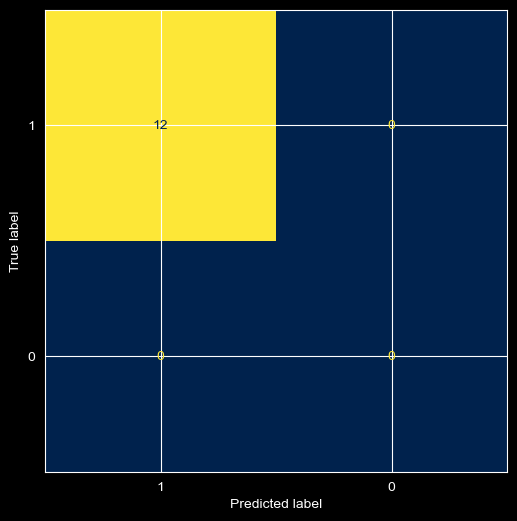

In [36]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(6, 6))
X_df_cfe_exp_genetic_TN = df_cfe_exp_genetic_TN.drop(["Event_Y_N"], axis=1)
Y_df_cfe_exp_genetic_TN = df_cfe_exp_genetic_TN['Event_Y_N']
Y_df_cfe_exp_genetic_TN_pred = RandomForestClassifier_sep_cfe.predict(X_df_cfe_exp_genetic_TN)
cm2 = confusion_matrix(Y_df_cfe_exp_genetic_TN, Y_df_cfe_exp_genetic_TN_pred, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[1, 0])
disp.plot(ax=ax, cmap='cividis', colorbar=False)
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(colors='white')

plt.show()

In [37]:
# --- 2. Log accuracy and metrics for CFEs ---
acc_cfe_tp = RandomForestClassifier_sep_cfe.score(X_df_cfe_exp_genetic_TP, Y_df_cfe_exp_genetic_TP)
acc_cfe_tn = RandomForestClassifier_sep_cfe.score(X_df_cfe_exp_genetic_TN, Y_df_cfe_exp_genetic_TN)
wandb.log({"Accuracy_of_CFE_for_TruePositive_Input_Instances": acc_cfe_tp})
wandb.log({"Accuracy_of_CFE_for_TrueNegative_Input_Instances": acc_cfe_tn})

In [38]:
from sklearn.metrics import classification_report
report_tp = classification_report(Y_df_cfe_exp_genetic_TP, Y_df_cfe_exp_genetic_TP_pred)
report_tn = classification_report(Y_df_cfe_exp_genetic_TN, Y_df_cfe_exp_genetic_TN_pred)
wandb.log({"ClassificationReport_CFE_TP": wandb.Html(f"<pre>{report_tp}</pre>")})
wandb.log({"ClassificationReport_CFE_TN": wandb.Html(f"<pre>{report_tn}</pre>")})

In [40]:
wandb.log({
    "CFE_TruePositive": wandb.Table(dataframe=df_cfe_exp_genetic_TP.head(50)),
    "CFE_TrueNegative": wandb.Table(dataframe=df_cfe_exp_genetic_TN.head(50))
})

In [53]:
def fidelity_score(cfs, model, desired_class):
    preds = model.predict(cfs)  # outputs 0/1
    num_correct = np.sum(preds == desired_class)
    total = len(cfs)
    return num_correct / total

fidelity_scoreTP=fidelity_score(X_df_cfe_exp_genetic_TP,RandomForestClassifier_sep_cfe,0)*100
fidelity_scoreTN=fidelity_score(X_df_cfe_exp_genetic_TN,RandomForestClassifier_sep_cfe,1)*100

In [54]:
fidelity_scoreTP

100.0

In [55]:
fidelity_scoreTN

100.0

In [48]:
wandb.log({"Fidelity Score of True Positive Input Instances and their counterfactuals":fidelity_scoreTP,
"Fidelity Score of True Negative Input Instances and their counterfactuals": fidelity_scoreTN})

Error: You must call wandb.init() before wandb.log()

In [46]:
wandb.finish()

Accuracy_of_CFE_for_TrueNegative_Input_Instances,▁
Accuracy_of_CFE_for_TruePositive_Input_Instances,▁
Fidelity Score of True Negative Input Instances and their counterfactuals,▁
Fidelity Score of True Positive Input Instances and their counterfactuals,▁
Accuracy_of_CFE_for_TrueNegative_Input_Instances,1
Accuracy_of_CFE_for_TruePositive_Input_Instances,1
Fidelity Score of True Negative Input Instances and their counterfactuals,0
Fidelity Score of True Positive Input Instances and their counterfactuals,100
